# **Algorithmic Methods for Data Mining: Homework 4**

**Author:** Roberto Magno Mazzotta , Gabriel Pinos

*MSc. in Data Science, Sapienza University of Rome*


## **0. Uploading the Classes and Modules**

Before doing any kind of analysis it is necessary to upload both the relevant Classes and Modules we will use to work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to datasets
path = "/Users/roberto/Desktop/HM4-ADM/datasets"
tag_df = pd.read_csv(f"{path}/tag.csv")
rating_df = pd.read_csv(f"{path}/rating.csv")
movie_df = pd.read_csv(f"{path}/movie.csv")
link_df = pd.read_csv(f"{path}/link.csv")
genome_scores_df = pd.read_csv(f"{path}/genome_scores.csv")
genome_tags_df = pd.read_csv(f"{path}/genome_tags.csv")



## **1. Recommendation System**

In this homework, we were asked to implement our version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input a user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

### **1.1. The Dataset**

We were provided with a [dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=rating.csv) that describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. 

It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.


The data are contained in six files.


- **tag.csv**: contains tags applied to movies by users:
    >- userId
    >- movieId
    >- tag
    >- timestamp

- **rating.csv**: contains ratings of movies by users:
    >- userId
    >- movieId
    >- rating
    >- timestamp

- **movie.csv**: contains movie information:
    >- movieId
    >- title
    >- genres

- **link.csv**: contains identifiers that can be used to link to other sources:
    >- movieId
    >- imdbId
    >- tmbdId

- **genome_scores.csv**: contains movie-tag relevance data:
    >- movieId
    >- tagId
    >- relevance
- **genome_tags.csv**: contains tag descriptions:
    >- tagId
    >- tag



In [2]:
# Inspect datasets
display("Tags Dataset:\n", tag_df.head())
display("Ratings Dataset:\n", rating_df.head())
display("Movies Dataset:\n", movie_df.head())
display("Links Dataset:\n", link_df.head())
display("Genome Scores Dataset:\n", genome_scores_df.head())
display("Genome Tags Dataset:\n", genome_tags_df.head())

'Tags Dataset:\n'

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


'Ratings Dataset:\n'

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


'Movies Dataset:\n'

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


'Links Dataset:\n'

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


'Genome Scores Dataset:\n'

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


'Genome Tags Dataset:\n'

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


## Preprocess the dataset 

In [3]:
import pandas as pd

# Preprocess Tags
tag_df['tag'] = tag_df['tag'].fillna('No Tag')  # Fill missing tags
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])  # Convert timestamp to datetime

# Preprocess Ratings
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])  # Convert timestamp to datetime

# Preprocess Movies
movie_df['genres'] = movie_df['genres'].fillna('Unknown')  # Fill missing genres
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)  # Extract year
movie_df['genres'] = movie_df['genres'].str.split('|')  # Split genres into lists

# Preprocess Links
link_df = link_df.fillna(0)  # Fill missing external IDs

# Preprocess Genome Scores
genome_scores_df = genome_scores_df.fillna(0)  # Fill missing values

# Preprocess Genome Tags
genome_tags_df['tag'] = genome_tags_df['tag'].fillna('No Tag')  # Fill missing tags

### Maybe will remove from here up to cell 18'

 #### **Preprocess rating_df**
> -	Convert timestamp to datetime format.

In [17]:
# Preprocess Tags
tag_df['tag'] = tag_df['tag'].fillna('No Tag')  # Fill missing tags
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])  # Convert timestamp to datetime

print("Tag Dataset After Preprocessing:")
display(tag_df.info())
display(tag_df.head())

Tag Dataset After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     465564 non-null  int64         
 1   movieId    465564 non-null  int64         
 2   tag        465564 non-null  object        
 3   timestamp  465564 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 14.2+ MB


None

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


#### **Preprocess movie_df**
> -	Fill missing values in genres with “Unknown”.
> -	Extract year from title.
> -	Split genres into a list.

In [9]:
# Preprocess Movies
movie_df['genres'] = movie_df['genres'].fillna('Unknown')  # Fill missing genres
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)  # Extract year
movie_df['genres'] = movie_df['genres'].str.split('|')  # Split genres into lists

print("Movie Dataset After Preprocessing:")
display(movie_df.info())
display(movie_df.head())

Movie Dataset After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   title    27278 non-null  object 
 2   genres   0 non-null      float64
 3   year     27256 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 852.6+ KB


None

,movieId,title,genres,year
0,1,Toy Story (1995),NaN,1995.0
1,2,Jumanji (1995),NaN,1995.0
2,3,Grumpier Old Men (1995),NaN,1995.0
3,4,Waiting to Exhale (1995),NaN,1995.0
4,5,Father of the Bride Part II (1995),NaN,1995.0


####  **Preprocess link_df**
> - Fill missing values in imdbId and tmdbId.

In [10]:
# Preprocess Links
link_df = link_df.fillna(0)  # Fill missing external IDs

print("Link Dataset After Preprocessing:")
display(link_df.info())
display(link_df.head())

Link Dataset After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27278 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB


None

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


####  **Preprocess genome_scores_df**
> - Fill missing values in relevance.

In [11]:
# Preprocess Genome Scores
genome_scores_df['relevance'] = genome_scores_df['relevance'].fillna(0)  # Fill missing relevance values

print("Genome Scores Dataset After Preprocessing:")
display(genome_scores_df.info())
display(genome_scores_df.head())

Genome Scores Dataset After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


None

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


####  **Preprocess genome_tags_df**

> - 	Handle missing values in tag.

In [16]:
# Preprocess Genome Tags
genome_tags_df['tag'] = genome_tags_df['tag'].fillna('No Tag')  # Fill missing tags

print("Genome Tags Dataset After Preprocessing:")
display(genome_tags_df.info())
display(genome_tags_df.head())

Genome Tags Dataset After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


None

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### **Minhash Signatures**

As a next step, we were asked to use the **userId** and **movieId**  column to try to implement min-hash signatures in order that users with similar interests in a genre appear in the same bucket. To do this we used the custom-made `minHash` class we built specifically for this homework. For more information on the **implementation** of the code behind it, please refer to the `lsh_functions` file included in the `libs` folder of this repository.

We can initialize our class:

In [7]:
# Import necessary functions
from libs.lsh_functions import ( 
    create_characteristic_matrix, 
    generate_minhash_signatures, 
    compute_jaccard_similarity, 
    compute_similarities, 
    recommend_movies, 
    plot_probability_curve, 
    visualize_signature_matrix, 
    create_sparse_interaction_matrix, 
    generate_minhash_signatures_with_interaction
)

Now, in order to perform Minhashing, we must perform the following steps:

#### **1.2.1. Shingling**

In this case, we define each different **movieId** as a shingle and represent our users as sets of shingles. Shingles are essentially the unique identifiers (IDs) of the movies that a user has interacted with or rated.

For example, we can represent a user A as:

$$A = \{\text{movie1}, \text{movie2}, \text{movie2}, \dots\},$$

Where the set contains the movieId values corresponding to the movies that the user  A  has watched or rated.

This representation captures the set of movies associated with each user, which is the fundamental input for building the characteristic matrix and applying MinHashing.

We can extract the movie shingles for every user in our dataset. For example, user 1 can be represented by their movie shingles as follows:

In [5]:
user_movies = rating_df.groupby('userId')['movieId'].apply(list)
print(f"Movies watched by User 1: {user_movies[1]}")

Movies watched by User 1: [2, 29, 32, 47, 50, 112, 151, 223, 253, 260, 293, 296, 318, 337, 367, 541, 589, 593, 653, 919, 924, 1009, 1036, 1079, 1080, 1089, 1090, 1097, 1136, 1193, 1196, 1198, 1200, 1201, 1208, 1214, 1215, 1217, 1219, 1222, 1240, 1243, 1246, 1249, 1258, 1259, 1261, 1262, 1266, 1278, 1291, 1304, 1321, 1333, 1348, 1350, 1358, 1370, 1374, 1387, 1525, 1584, 1750, 1848, 1920, 1967, 1994, 1997, 2021, 2100, 2118, 2138, 2140, 2143, 2173, 2174, 2193, 2194, 2253, 2288, 2291, 2542, 2628, 2644, 2648, 2664, 2683, 2692, 2716, 2761, 2762, 2804, 2872, 2918, 2944, 2947, 2959, 2968, 3000, 3030, 3037, 3081, 3153, 3265, 3438, 3476, 3479, 3489, 3499, 3889, 3932, 3996, 3997, 4011, 4027, 4105, 4128, 4133, 4226, 4306, 4446, 4467, 4571, 4720, 4754, 4878, 4896, 4911, 4915, 4941, 4980, 4993, 5026, 5039, 5040, 5146, 5171, 5540, 5679, 5797, 5816, 5898, 5952, 5999, 6093, 6242, 6333, 6502, 6539, 6754, 6755, 6774, 6807, 6834, 6888, 7001, 7045, 7046, 7153, 7164, 7247, 7387, 7389, 7438, 7449, 7454, 7482

In [6]:
# Merge rating_df with movie_df to include movie titles
merged_df = pd.merge(rating_df, movie_df, on='movieId')

# Display the first few rows
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",1995.0
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"[Mystery, Sci-Fi, Thriller]",1995.0
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",1995.0
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",1995.0


Here we can see that the movies watched by each user (e.g., User `1`) are represented by their unique `movieId` values. This gives us insight into the specific movies a user has interacted with. We can do this for every user and represent each individual user by the set of `movieId`s they have rated or interacted with. However, to effectively compare users, we need to represent them in a way that accounts for all possible movies regardless of the order in which they appear.

###  **Building the Characteristic Matrix**

Once we've represented each of our users using their `movieId` shingles, we can construct the **characteristic matrix** for users. In this matrix:

- Each **column** corresponds to a unique user (`userId`).
- Each **row** corresponds to a unique movie (`movieId`) from the universal set of movies that appear in the dataset.

The value in the element  $(i, j)$  of the matrix is 1  if the movie in row $i$  has been rated or interacted with by the user in column $j$ ; otherwise, it is  0. The resulting matrix looks like this:

<br>

$$
\begin{pmatrix}
& \text{User ID 1}&\text{User ID 2}&\dots&\text{User $ID(n-1)$}&\text{User ID $n$}\\
\text{Movie ID 1} &1&0&\dots&0&1\\
\text{Movie ID 2} &0&0&\dots&1&0\\
\vdots &0&1&\dots&0&1\\
\text{Movie ID $m-1$} &1&0&\dots&1&1\\
\text{Movie ID $m$} &0&0&\dots&1&0
\end{pmatrix}
$$

<br>

For example, the first row represents **Movie 1**, and we can see that Users  1  and $n$  have interacted with this movie, while the others have not. Similarly, other rows correspond to different movies, and columns represent the one-hot encoded interaction of users with those movies.

We can think of this matrix as the **one-hot representation** of users based on the movies they have interacted with. This representation is critical for computing MinHash signatures.

For completeness, we can extract the column of this matrix for a specific user, such as User `1`, which gives the binary interaction vector of that user with the movies:


In [7]:
# Create a binary interaction matrix
interaction_matrix = pd.pivot_table(
    merged_df, 
    values='rating', 
    index='movieId', 
    columns='userId', 
    aggfunc=lambda x: 1,  # Use 1 to indicate interaction
    fill_value=0          # Fill with 0 for no interaction
)

interaction_matrix.head()

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_3516/2151508797.py:2: PerformanceWarning: The following operation may generate 3703856792 cells in the resulting pandas object.
  interaction_matrix = pd.pivot_table(


userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,1,0,1
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
from libs.lsh_functions import create_sparse_interaction_matrix

# Convert interaction matrix to sparse matrix
sparse_interaction_matrix = create_sparse_interaction_matrix(interaction_matrix)

In [9]:
from libs.lsh_functions import next_prime, generate_minhash_signatures_with_interaction

# Define parameters for MinHash
n_hashes = 100
a_values = np.random.randint(1, next_prime(interaction_matrix.shape[0]), size=n_hashes)
b_values = np.random.randint(0, next_prime(interaction_matrix.shape[0]), size=n_hashes)

# Generate MinHash signatures
signature_matrix = generate_minhash_signatures_with_interaction(
    sparse_interaction_matrix, n_hashes, a_values, b_values
)

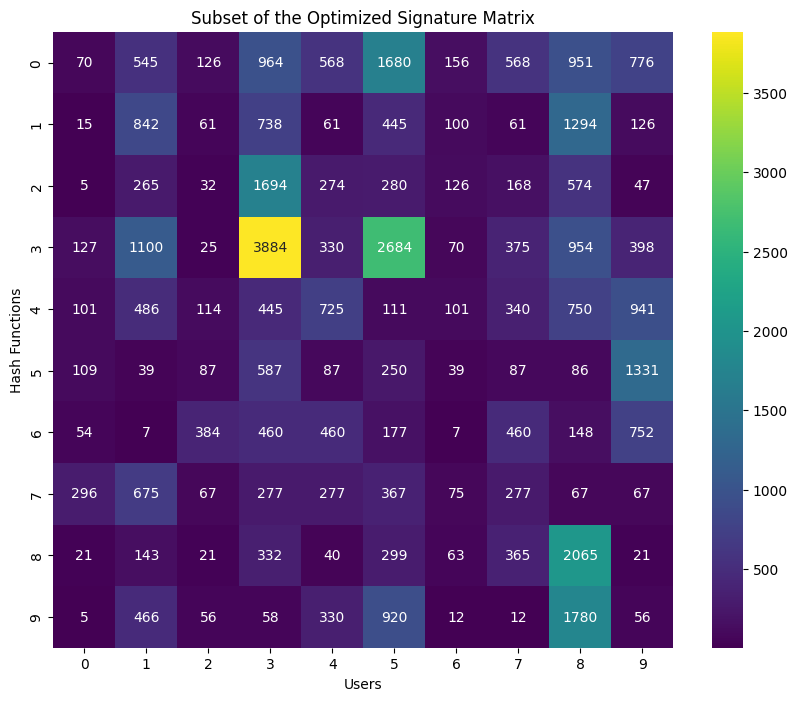

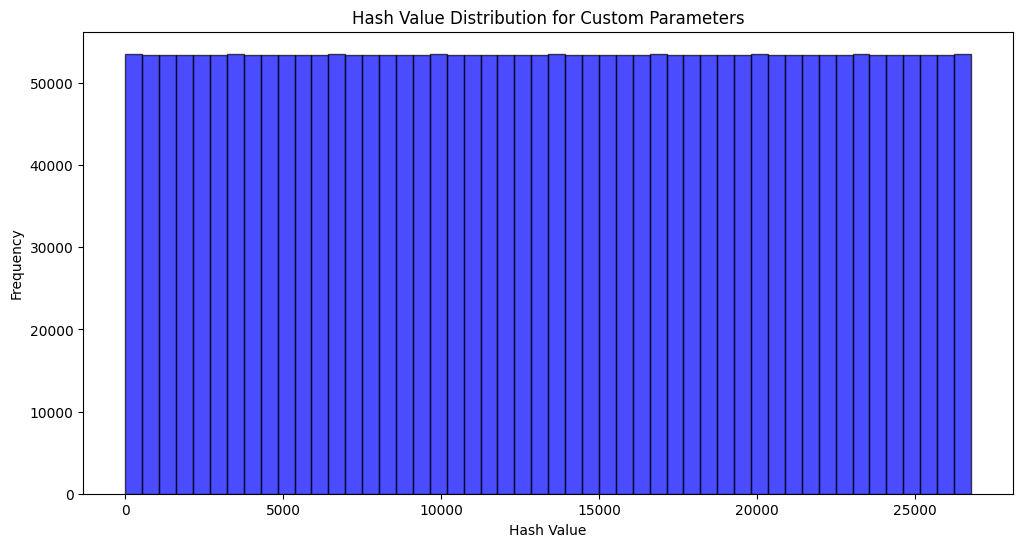

In [10]:
from libs.lsh_functions import plot_signature_matrix, plot_hash_param_effects

# Visualize the first 10x10 portion of the signature matrix
plot_signature_matrix(signature_matrix, rows=10, cols=10)

# Analyze the effect of hash function parameters
plot_hash_param_effects(n_hashes=100, movie_range=range(1, interaction_matrix.shape[0]))

In [11]:
from libs.lsh_functions import validate_signature_matrix, compute_estimated_jaccard, compute_actual_jaccard

In [ ]:
### compared with 
# Example Usage
print("Starting validation of MinHash Signature Matrix...")
actual_similarities, estimated_similarities = validate_signature_matrix(interaction_matrix.values, signature_matrix)

Starting validation of MinHash Signature Matrix...


/Users/roberto/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


As we can see, we only have 1 values in certain indexes representing the movies the user has rated. These correspond to the specific `movieId`s the user interacted with. Using this representation, we can compare users based on their rated movies. However, as the number of users and movies grows, this representation becomes inefficient due to the sparsity of the matrix. 

To address this issue, we replace the large characteristic matrix with a smaller **signature matrix** that still preserves the underlying similarity between users.

### **Min-Hashing**

We achieve this by building a **signature matrix** using **Min-Hashing**. To create this matrix from the characteristic matrix, we follow these steps:

1. **Randomly permute the rows** of the characteristic matrix. For example, rows `12345` might become `35421`, so if "Movie A" was in row 1, it would now be in row 5.

2. For each user (i.e., column), **find the position of the first non-zero value** (indicating a rated movie) in the permuted rows. This position is used to represent the user's interaction for that permutation.

3. **Repeat this process** as many times as desired, appending each result to the user's signature vector.

Instead of explicitly permuting the rows (which is computationally expensive), we use **hash functions** to simulate the permutation process. A hash function for an input integer $x$ is defined as:

$$
h(x) = (ax + b) \mod c
$$

where:
- $a$ and $b$ are random integers less than the number of rows of the matrix.
- $c$ is a **prime number** slightly larger than the number of rows.

This approach avoids true permutations and computes the hash values directly. While this may result in hash collisions (where two rows map to the same value), the effect can be minimized by choosing appropriate values for $a$, $b$, and $c$.

Using this framework, our algorithm proceeds as follows:

1. Initialize the **signature matrix** with all values set to $\infty$.

2. For each row, compute $h_1(r), h_2(r), \dots, h_n(r)$ for $n$ random hash functions.

3. For each column $c$ of row $r$:
    - If $c$ has a $0$ in row $r$, skip it.
    - If $c$ has a $1$ in row $r$, update $S(i, c)$ for each $i \in \{1, \dots, n\}$ to be the **minimum** of the current value of $S(i, c)$ and $h_i(r)$.

The resulting **signature matrix** has dimensions determined by the number of hash functions (or permutations) and the number of users.

For our Recommendation System, we chose **100 hash functions**, so the resulting signature matrix has dimensions:

'Shape of the signature matrix:'

(100, 5)

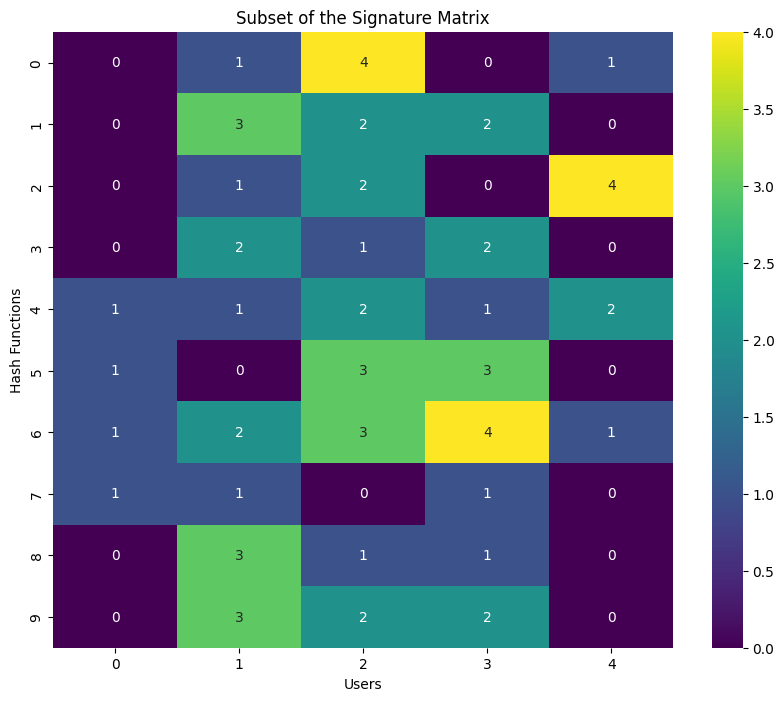

In [ ]:
# Import the custom functions from your library
from libs.lsh_functions import create_characteristic_matrix, generate_minhash_signatures, next_prime, visualize_signature_matrix


# A dictionary where keys are user IDs and values are sets of movie IDs watched by the user
user_movies = {
    1: {1, 2, 3},
    2: {3, 4},
    3: {5, 6},
    4: {1, 3, 5},
    5: {2, 4, 6}
}

# All movies in the dataset
all_movies = {1, 2, 3, 4, 5, 6}

# Create the characteristic matrix
characteristic_matrix = create_characteristic_matrix(None, all_movies, user_movies)

# Generate MinHash signatures with a specified number of hash functions
n_hashes = 100
signature_matrix = generate_minhash_signatures(characteristic_matrix, n_hashes)

# Obtain the shape of the signature matrix
display("Shape of the signature matrix:", signature_matrix.shape)

# Visualize the first 10 rows and columns of the signature matrix using a heatmap
visualize_signature_matrix(signature_matrix, rows=10, cols=10)

---

Through this method, we produce vectors of equal length that contain positive integer values representing the MinHash signatures for each user, based on the movies they have rated. These signatures allow us to approximate user similarity efficiently. Ideally, we want to hash users into **buckets** such that users with similar preferences (based on their movie lists) end up in the same bucket. However, if we hash based on the entire signature as a whole, only identical signatures would end up in the same bucket, which is not practical for approximate similarity searches.

In most cases, even though parts of two signatures may match, they might still be hashed into separate buckets. This is undesirable because it prevents us from identifying partially similar users. To address this, we use the **banding** technique.

#### **Banding and Bucketing**

The banding method addresses this issue by splitting the MinHash signature matrix into smaller sub-vectors called *bands*. Instead of hashing the entire signature for a user into a single bucket, we hash each band independently. For instance, splitting a 100-dimensional signature into 20 bands results in 20 opportunities to match users based on their sub-vector similarity.

While this increases the chance of false positives (users hashed into the same bucket despite being dissimilar), we can tune the trade-off by adjusting the number of bands (\(b\)) and the number of rows per band \($r$\). The probability of a pair of users being hashed into the same bucket given their Jaccard similarity \($s$\) is:

$$
\mathbb{P} = 1 - (1 - s^r)^b,
$$

where:

- \($b$)\: Number of bands (splits in the signature matrix).
- \($r$)\: Number of rows per band:
$$r = \frac{\text{signature length}}{b}$$


The **Jaccard Similarity** between users refers to the similarity between the sets of movies they have rated. We can visualize the effect of different banding configurations by plotting this probability for varying values of \($b$\):

```python
# Plot the probability of users being hashed into the same bucket as a function of their similarity
plot_probability_curve(n=100, band_values=[5, 20, 25, 50]) 

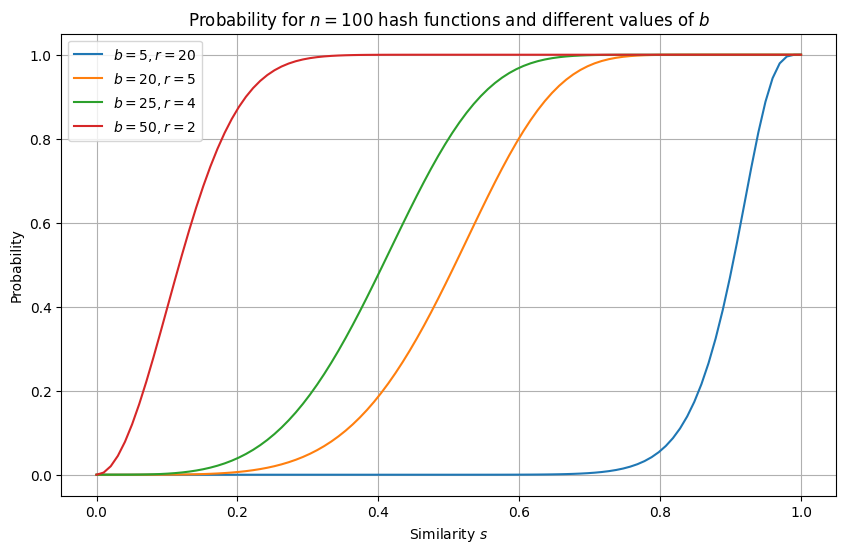

In [11]:
# Example: Plot the probability curve
plot_probability_curve(n=100, band_values=[5, 20, 25, 50])

### **Probability Plot for MinHash Banding**

This visualization shows the **probability of two users being hashed into the same bucket** as a function of their similarity $s$, based on different banding configurations in the MinHash algorithm.

#### **Key Aspects**

1. **Hash Functions ($n = 100$)**:
   - The total number of hash functions used to generate the MinHash signatures is fixed at $n = 100$.

2. **Banding Parameter ($b$)**:
   - The curves represent different values of $b$ (number of bands).
   - For example:
     - $b = 5$: Larger number of rows per band ($r = n / b = 20$).
     - $b = 50$: Smaller number of rows per band ($r = n / b = 2$).

3. **Trade-off Between $b$ and $r$**:
   - **Fewer bands ($b$) and more rows per band ($r$)**:
     - The curve is steeper, requiring higher similarity for users to be hashed to the same bucket.
     - Reduces false positives but increases false negatives.
   - **More bands ($b$) and fewer rows per band ($r$)**:
     - The curve is smoother, allowing even lower similarity pairs to hash into the same bucket.
     - Increases false positives but reduces false negatives.

4. **Interpretation of Similarity $s$**:
   - $s = 0$: Probability is $0$, meaning users with no similarity will not hash to the same bucket.
   - $s = 1$: Probability is $1$, meaning users with identical signatures will always hash to the same bucket.
   - Intermediate $s$ values (e.g., $s = 0.4, 0.6$): The probability increases as similarity grows, depending on $b$ and $r$.

5. **Use Case**:
   - This plot helps determine the optimal $b$ and $r$ configuration based on the desired trade-off between false positives and false negatives.

#### **Probability Formula**:
The probability of a pair of users being hashed into the same bucket is given by:
$$
\mathbb{P} = 1 - (1 - s^r)^b
$$
where:
- $b$: Number of bands.
- $r$: Number of rows per band $\left(r = \frac{\text{signature length}}{b}\right)$.

#### **Recommendation**
- For applications that require **high precision** (fewer false positives), choose configurations with fewer bands ($b = 5$ or $b = 10$).
- For applications that tolerate **false positives** but emphasize capturing similar users, choose configurations with more bands ($b = 25$ or $b = 50$).

---


##### with spark::

In [1]:
from libs.analysis_functions import (
    initialize_spark, load_data, preprocess_movies_ratings,
    calculate_avg_ratings_by_genre, calculate_ratings_by_year,
    inspect_data, save_to_csv, merge_datasets
)
import matplotlib.pyplot as plt

# Initialize Spark
spark = initialize_spark()

# Define dataset path
path = "/Users/roberto/Desktop/HM4-ADM/datasets"

# Load Data
tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df = load_data(spark, path)

24/12/02 22:00:01 WARN Utils: Your hostname, Robertos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.53 instead (on interface en0)
24/12/02 22:00:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 22:00:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Inspect the structure and content of the loaded DataFrames
print("Inspecting rating_df:")
inspect_data(rating_df, num_rows=10)  # Display top 10 rows of ratings

print("Inspecting movie_df:")
inspect_data(movie_df, num_rows=5)  # Display top 5 rows of movies

# Convert to Pandas for detailed inspection
movies_sample = inspect_data(movie_df, num_rows=5, convert_to_pandas=True)
print(movies_sample)

Inspecting rating_df:
+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
|     1|    112|   3.5|2004-09-10 03:09:00|
|     1|    151|   4.0|2004-09-10 03:08:54|
|     1|    223|   4.0|2005-04-02 23:46:13|
|     1|    253|   4.0|2005-04-02 23:35:40|
|     1|    260|   4.0|2005-04-02 23:33:46|
+------+-------+------+-------------------+
only showing top 10 rows

Inspecting movie_df:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|  

In [3]:
# Preprocess movies and ratings data
movies_ratings_df = preprocess_movies_ratings(movie_df, rating_df)

# Inspect preprocessed data
print("Inspecting movies_ratings_df after preprocessing:")
inspect_data(movies_ratings_df, num_rows=5)

# Calculate average ratings by genre
avg_ratings_by_genre = calculate_avg_ratings_by_genre(movies_ratings_df)

# Calculate ratings by year
ratings_by_year = calculate_ratings_by_year(movies_ratings_df)

Inspecting movies_ratings_df after preprocessing:
+-------+--------------------+--------------------+------+------+-------------------+----+---------+
|movieId|               title|              genres|userId|rating|          timestamp|year|    genre|
+-------+--------------------+--------------------+------+------+-------------------+----+---------+
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005|Adventure|
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005| Children|
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005|  Fantasy|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|2005|Adventure|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|2005|    Drama|
+-------+--------------------+--------------------+------+------+-------------------+----+---------+
only showing top 5 rows



- **Merge the Dataset** :

The six files contain complementary information that can be combined using shared keys like **userId**, **movieId**, and **tagId**. Below is an explanation of each file’s role and how they are merged to form a unified dataset.

In [4]:
import libs

In [12]:
from libs.analysis_functions import merge_datasets

In [13]:
# Import necessary modules
from libs.analysis_functions import initialize_spark, load_data, merge_datasets, inspect_data

# Initialize Spark session
spark = initialize_spark()

# Load datasets
path = "/Users/roberto/Desktop/HM4-ADM/datasets"  # Update with the actual path to your dataset
tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df = load_data(spark, path)

# Merge datasets into a single DataFrame
final_dataset = merge_datasets(tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df)

# Visualize the merged dataset
print("Dataset Schema:")
final_dataset.printSchema()  # Display the schema of the DataFrame

print("\nSample Rows:")
final_dataset.show(10)  # Display the first 10 rows of the dataset

Dataset Schema:
root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = false)
 |-- rating: double (nullable = true)
 |-- rating_timestamp: timestamp (nullable = true)
 |-- user_tag: string (nullable = false)
 |-- tag_timestamp: timestamp (nullable = true)
 |-- tagId: integer (nullable = true)
 |-- relevance: double (nullable = false)
 |-- genome_tag: string (nullable = true)
 |-- rating_date: date (nullable = true)


Sample Rows:


+-------+------+--------------------+------------------+------+-------------------+--------+-------------+-----+---------+------------+-----------+
|movieId|userId|               title|            genres|rating|   rating_timestamp|user_tag|tag_timestamp|tagId|relevance|  genome_tag|rating_date|
+-------+------+--------------------+------------------+------+-------------------+--------+-------------+-----+---------+------------+-----------+
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    1|  0.04275|         007| 1999-10-23|
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    2|  0.05125|007 (series)| 1999-10-23|
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    3|  0.02875|18th century| 1999-10-23|
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    4|

1.2###

## **1.2 Minhash Signatures**
Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

**Important**: Implement your MinHash function from scratch—do not use any pre-built hash functions.
Use your MinHash function to generate signature vectors for each user based on their rated movies.
Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.
Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the book may be helpful as a reference.

In [2]:
# Import necessary libraries and functions
from pyspark.sql.functions import collect_set, col
from libs.minhash_functions import MinHashSpark
import matplotlib.pyplot as plt

from libs.analysis_functions import (
    initialize_spark, load_data, preprocess_movies_ratings,
    calculate_avg_ratings_by_genre, calculate_ratings_by_year,
    inspect_data, save_to_csv
)

# Initialize Spark
spark = initialize_spark()

# Define dataset path
path = "/Users/roberto/Desktop/HM4-ADM/datasets"

# Load Data
tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df = load_data(spark, path)

# Preprocess movies and ratings data
movies_ratings_df = preprocess_movies_ratings(movie_df, rating_df)

# Aggregate movies watched by each user
user_movies_df = (
    movies_ratings_df
    .groupBy("userId")
    .agg(collect_set("movieId").alias("movieIds"))
)

# Initialize MinHash
num_hashes = 50
minhash = MinHashSpark(num_hashes=num_hashes)

# Compute MinHash signatures
user_movies_with_signature = user_movies_df.withColumn(
    "signature", minhash.compute_signature_udf()(col("movieIds"))
)

# Inspect the signatures
print("User MinHash Signatures:")
inspect_data(user_movies_with_signature, num_rows=5)

# Example: Compute Jaccard similarity between the first two users
users = user_movies_with_signature.limit(2).collect()
user1_sig = users[0]["signature"]
user2_sig = users[1]["signature"]
similarity = minhash.jaccard_similarity(user1_sig, user2_sig)

print(f"Jaccard Similarity (MinHash) between User 1 and User 2: {similarity:.4f}")

# Visualize Jaccard similarities for all users
user_signatures = user_movies_with_signature.collect()
similarities = []
for i in range(len(user_signatures)):
    for j in range(i + 1, len(user_signatures)):
        sim = minhash.jaccard_similarity(
            user_signatures[i]["signature"],
            user_signatures[j]["signature"]
        )
        similarities.append(sim)

# Plot similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=30, alpha=0.7)
plt.title("Jaccard Similarity Distribution Between Users (MinHash)")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Experiment with threshold values
thresholds = [0.2, 0.4, 0.6, 0.8]
results = []

for threshold in thresholds:
    similar_pairs = sum(1 for sim in similarities if sim >= threshold)
    results.append((threshold, similar_pairs))

# Plot results
threshold_df = pd.DataFrame(results, columns=["Threshold", "Number of Similar Pairs"])
threshold_df.plot(x="Threshold", y="Number of Similar Pairs", kind="bar", legend=False)
plt.title("Number of Similar User Pairs at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Number of Pairs")
plt.tight_layout()
plt.show()

User MinHash Signatures:


+------+--------------------+--------------------+
|userId|            movieIds|           signature|
+------+--------------------+--------------------+
|    26|[356, 589, 539, 3...|[3813, 977, 182, ...|
|    27|[3508, 539, 235, ...|[1108, 169, 38, 8...|
|    28|[161, 356, 509, 3...|[3813, 977, 182, ...|
|    31|[4366, 78469, 330...|[1207, 153, 162, ...|
|    34|[466, 356, 589, 6...|[25, 272, 182, 34...|
+------+--------------------+--------------------+
only showing top 5 rows



Jaccard Similarity (MinHash) between User 1 and User 2: 0.0400


: 

: 

It’s normal for MinHash computations to take some time, especially when the dataset is large and you’re generating multiple hash signatures for each user. However, there are optimizations and improvements you can make to reduce runtime.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MovieLens Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

24/11/25 21:48:33 WARN Utils: Your hostname, Robertos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.51 instead (on interface en0)
24/11/25 21:48:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/25 21:48:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
user_movies_df = (
    movies_ratings_df
    .groupBy("userId")
    .agg(collect_set("movieId").alias("movieIds"))
    .limit(500)  # Use only 500 users for testing
)

In [4]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

def calculate_jaccard(sig1, sig2):
    """
    Compute Jaccard similarity between two signatures.
    """
    intersection = len(set(sig1) & set(sig2))
    union = len(set(sig1) | set(sig2))
    return float(intersection) / float(union) if union != 0 else 0.0

# Register as UDF
jaccard_udf = udf(calculate_jaccard, FloatType())

# Generate all pairs of users
user_pairs = user_movies_with_signature.alias("u1").crossJoin(
    user_movies_with_signature.alias("u2")
).filter(col("u1.userId") < col("u2.userId"))

# Compute similarities
user_pairs_with_similarity = user_pairs.withColumn(
    "similarity",
    jaccard_udf(col("u1.signature"), col("u2.signature"))
)

# Filter based on a threshold
threshold = 0.2
similar_users = user_pairs_with_similarity.filter(col("similarity") >= threshold)

similar_users.show(5)  # Inspect results

+------+--------------------+--------------------+------+--------------------+--------------------+----------+
|userId|            movieIds|           signature|userId|            movieIds|           signature|similarity|
+------+--------------------+--------------------+------+--------------------+--------------------+----------+
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|    28|[161, 356, 509, 3...|[5294, 9540, 5117...|0.22222222|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   108|[466, 356, 589, 5...|[247, 5157, 280, ...|0.20731707|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   183|[161, 589, 153, 2...|[4294, 1088, 280,...|0.20987654|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   243|[356, 153, 590, 3...|[10392, 1088, 280...|0.25316456|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   296|[153, 1, 590, 2, ...|[2596, 5314, 1720...|0.22222222|
+------+--------------------+--------------------+------+--------------------+--------------------+----------+
o

In [5]:
print("Inspecting intermediate results...")
inspect_data(user_movies_with_signature, num_rows=5)

Inspecting intermediate results...


+------+--------------------+--------------------+
|userId|            movieIds|           signature|
+------+--------------------+--------------------+
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|
|    27|[3508, 539, 235, ...|[1204, 4441, 1157...|
|    28|[161, 356, 509, 3...|[5294, 9540, 5117...|
|    31|[4366, 78469, 330...|[306, 493, 86, 13...|
|    34|[466, 356, 589, 6...|[996, 7592, 538, ...|
+------+--------------------+--------------------+
only showing top 5 rows



In [6]:
spark = SparkSession.builder \
    .appName("MovieLens Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "100s") \
    .getOrCreate()

24/11/25 21:49:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## *Optimizations*, 
#### I need to put this in libs.py soon

In [9]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, col, lit
import numpy as np
import random
import matplotlib.pyplot as plt

# Initialize Spark
def initialize_spark(app_name="Movie Recommendation System"):
    return SparkSession.builder.appName(app_name).getOrCreate()

# Load data
def load_data(spark, path):
    rating_df = spark.read.csv(f"{path}/rating.csv", header=True, inferSchema=True)
    return rating_df

# MinHash Function (Implemented from scratch)
class MinHash:
    def __init__(self, num_hashes):
        self.num_hashes = num_hashes
        self.hash_functions = self._generate_hash_functions()

    def _generate_hash_functions(self):
        # Generate random coefficients for hash functions
        max_val = 2**32 - 1
        return [
            (random.randint(1, max_val), random.randint(1, max_val))
            for _ in range(self.num_hashes)
        ]

    def compute_signature(self, user_movies):
        """
        Compute the MinHash signature for a set of movies (user_movies).
        """
        signature = []
        for a, b in self.hash_functions:
            min_hash = min((a * movie + b) % (10**9 + 7) for movie in user_movies)
            signature.append(min_hash)
        return signature

# Locality-Sensitive Hashing (LSH)
class LSH:
    def __init__(self, num_bands, rows_per_band):
        self.num_bands = num_bands
        self.rows_per_band = rows_per_band

    def hash_signature(self, signature):
        """
        Group MinHash signature into bands and hash each band.
        """
        assert len(signature) == self.num_bands * self.rows_per_band
        band_hashes = []
        for i in range(self.num_bands):
            band = tuple(signature[i * self.rows_per_band:(i + 1) * self.rows_per_band])
            band_hashes.append(hash(band))
        return band_hashes

# Preprocess the data
def preprocess_data(rating_df):
    """
    Group movies watched by each user and return a DataFrame with userId and movieIds.
    """
    user_movies_df = rating_df.groupBy("userId").agg(collect_set("movieId").alias("movieIds"))
    return user_movies_df

# Jaccard Similarity
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

def generate_recommendations(user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets):
    """
    Generate movie recommendations for a given user using LSH buckets.
    """
    # Find similar users in the same LSH buckets
    if user_id not in user_to_buckets:
        print(f"User {user_id} not found in LSH buckets.")
        return []

    user_bands = user_to_buckets[user_id]
    similar_users = set()
    for band_hash in user_bands:
        if band_hash in lsh_buckets:
            similar_users.update(lsh_buckets[band_hash])

    similar_users.discard(user_id)  # Remove the user itself from similar users

    # Aggregate movies watched by similar users, excluding movies already watched
    user_movies = set(user_movies_df.filter(col("userId") == user_id).collect()[0]["movieIds"])
    candidate_movies = set()
    for similar_user in similar_users:
        similar_user_movies = set(user_movies_df.filter(col("userId") == similar_user).collect()[0]["movieIds"])
        candidate_movies.update(similar_user_movies)
    
    recommendations = candidate_movies - user_movies
    return recommendations

# Main Recommendation System Implementation
def recommendation_system(path, num_hashes=50, num_bands=5):
    """
    Full implementation of the recommendation system.
    """
    spark = initialize_spark()

    # Load data
    rating_df = load_data(spark, path)

    # Preprocess data
    user_movies_df = preprocess_data(rating_df)

    # Initialize MinHash
    minhash = MinHash(num_hashes=num_hashes)

    # Compute MinHash signatures for all users
    user_signatures = {}
    for row in user_movies_df.collect():
        user_id = row["userId"]
        movie_ids = row["movieIds"]
        user_signatures[user_id] = minhash.compute_signature(movie_ids)

    # Initialize LSH
    rows_per_band = num_hashes // num_bands
    lsh = LSH(num_bands=num_bands, rows_per_band=rows_per_band)

        # Create LSH buckets and user-to-bucket mappings
    lsh_buckets = {}
    user_to_buckets = {}

    for user_id, signature in user_signatures.items():
        band_hashes = lsh.hash_signature(signature)
        user_to_buckets[user_id] = band_hashes  # Map user to their bands
        for band_hash in band_hashes:
            if band_hash not in lsh_buckets:
                lsh_buckets[band_hash] = []
            lsh_buckets[band_hash].append(user_id)

    # Generate Recommendations for a sample user
    sample_user_id = 1
    recommendations = generate_recommendations(sample_user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets)

    print(f"Recommended movies for User {sample_user_id}: {recommendations}")

# Call the recommendation system
if __name__ == "__main__":
    dataset_path = "/Users/roberto/Desktop/HM4-ADM/datasets"
    recommendation_system(dataset_path, num_hashes=50, num_bands=5)

Recommended movies for User 1: set()


## **1.3 Locality-Sensitive Hashing (LSH)**
Now that you have generated MinHash user signatures, apply Locality-Sensitive Hashing (LSH) to cluster similar users.

Bucket Creation: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

Debugging Tip: After creating buckets, check a few bucket contents to verify that multiple users are being grouped in the same buckets.
Query: For a given user, identify the two most similar users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.

Movie Recommendation Logic:

If both similar users have rated a movie, recommend this movie based on the average rating.
If there are no commonly rated movies, recommend the top-rated movies of the most similar user.
Final Recommendation: Provide at most five movies to the user.

Example recommendation logic for a user:

| User | Movie Title  | Rating |
|------|--------------|--------|
| A    | Inception    | 4.5    |
| A    | Titanic      | 4.2    |
| A    | Avatar       | 2.8    |
| B    | Inception    | 4.6    |
| B    | The Matrix   | 3.9    |
| B    | Toy Story    | 4.7    |
| C    | Titanic      | 3.8    |
| C    | Avatar       | 4.3    |
| C    | Shrek        | 4.1    |

If User A and User B are identified as the two most similar users to User X, the recommended movies would be:

Common Movies: "Inception" (average rating: 4.55).
Top-rated from Most Similar User: "Toy Story" (4.7) from User B and "Titanic" (4.2) from User A.
If fewer than 5 movies are found, complete the list using other high-rated movies by the most similar users.

In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, col
from pyspark.sql.types import IntegerType
import random
import matplotlib.pyplot as plt
import pandas as pd

# MinHash Implementation
class MinHash:
    def __init__(self, num_hashes=50):
        self.num_hashes = num_hashes
        self.hash_funcs = self.generate_hash_functions()

    def generate_hash_functions(self):
        """
        Generate a list of hash functions of the form:
        h(x) = (a * x + b) % p
        """
        p = 2**31 - 1  # Large prime number
        hash_funcs = []
        for _ in range(self.num_hashes):
            a = random.randint(1, p - 1)
            b = random.randint(0, p - 1)
            hash_funcs.append((a, b))
        return hash_funcs

    def compute_signature(self, movie_ids):
        """
        Compute the MinHash signature for a given list of movie IDs.
        """
        signature = []
        for a, b in self.hash_funcs:
            min_hash = min((a * x + b) % (2**31 - 1) for x in movie_ids)
            signature.append(min_hash)
        return signature

# LSH Implementation
class LSH:
    def __init__(self, num_bands):
        self.num_bands = num_bands

    def hash_signature(self, signature):
        """
        Hash a signature into `num_bands` bands.
        """
        band_size = len(signature) // self.num_bands
        band_hashes = []
        for i in range(self.num_bands):
            band = signature[i * band_size: (i + 1) * band_size]
            band_hash = hash(tuple(band))
            band_hashes.append(band_hash)
        return band_hashes

# Spark Session Initialization
def initialize_spark(app_name="Movie Recommendation System"):
    return SparkSession.builder.appName(app_name).getOrCreate()

# Load Dataset
def load_data(spark, path):
    """
    Load MovieLens datasets into Spark DataFrames.
    """
    rating_df = spark.read.csv(f"{path}/rating.csv", header=True, inferSchema=True)
    movie_df = spark.read.csv(f"{path}/movie.csv", header=True, inferSchema=True)
    return rating_df, movie_df

# Preprocessing
def preprocess_data(rating_df):
    """
    Preprocess ratings data to create a list of movies watched by each user.
    """
    user_movies_df = (
        rating_df.groupBy("userId")
        .agg(collect_set("movieId").alias("movieIds"))
    )
    return user_movies_df

# Generate Recommendations
def generate_recommendations(user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets):
    """
    Generate movie recommendations for a given user using LSH buckets.
    """
    if user_id not in user_to_buckets:
        print(f"[ERROR] User {user_id} not found in LSH buckets.")
        return []

    user_bands = user_to_buckets[user_id]
    similar_users = set()
    for band_hash in user_bands:
        if band_hash in lsh_buckets:
            similar_users.update(lsh_buckets[band_hash])

    similar_users.discard(user_id)
    user_movies = set(user_movies_df.filter(col("userId") == user_id).collect()[0]["movieIds"])
    candidate_movies = set()
    for similar_user in similar_users:
        similar_user_movies = set(user_movies_df.filter(col("userId") == similar_user).collect()[0]["movieIds"])
        candidate_movies.update(similar_user_movies)

    recommendations = candidate_movies - user_movies
    return recommendations

# Recommendation System Workflow
def recommendation_system(dataset_path, num_hashes=50, num_bands=5):
    # Step 1: Initialize Spark
    spark = initialize_spark()

    # Step 2: Load Data
    rating_df, movie_df = load_data(spark, dataset_path)

    # Step 3: Preprocess Data
    user_movies_df = preprocess_data(rating_df)

    # Step 4: MinHash Signature Computation
    minhash = MinHash(num_hashes=num_hashes)
    user_signatures = {}
    for row in user_movies_df.collect():
        user_signatures[row["userId"]] = minhash.compute_signature(row["movieIds"])

    # Step 5: Locality-Sensitive Hashing (LSH)
    lsh = LSH(num_bands=num_bands)
    lsh_buckets = {}
    user_to_buckets = {}

    for user_id, signature in user_signatures.items():
        band_hashes = lsh.hash_signature(signature)
        user_to_buckets[user_id] = band_hashes
        for band_hash in band_hashes:
            if band_hash not in lsh_buckets:
                lsh_buckets[band_hash] = []
            lsh_buckets[band_hash].append(user_id)

    # Debugging: Print the first 5 LSH buckets
    print("\n=== Debug: LSH Buckets ===")
    for band_hash, users in list(lsh_buckets.items())[:5]:
        print(f"Band {band_hash}: Users: {users}")

    # Step 6: Generate Recommendations for a Sample User
    sample_user_id = 1
    print(f"\nGenerating recommendations for User {sample_user_id}...")
    recommendations = generate_recommendations(sample_user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets)
    print(f"Recommended movies for User {sample_user_id}: {recommendations}")

    def inspect_lsh_buckets(lsh_buckets):
        print("\n=== Debug: Inspecting LSH Buckets ===")
        for i, (band_hash, users) in enumerate(lsh_buckets.items()):
            if i >= 5:  # Limit to inspecting 5 buckets
                break
            print(f"Band {band_hash}: Users: {users}")

    # Stop Spark session
    spark.stop()


# Run the Recommendation System
if __name__ == "__main__":
    dataset_path = "/Users/roberto/Desktop/HM4-ADM/datasets"  # Replace with your dataset path
    recommendation_system(dataset_path, num_hashes=50, num_bands=5)

24/12/04 22:13:56 WARN Utils: Your hostname, Robertos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.53 instead (on interface en0)
24/12/04 22:13:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/04 22:13:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



=== Debug: LSH Buckets ===
Band -2149023544295741073: Users: [26]
Band 4094252399654784968: Users: [26, 53467, 61924, 21585, 72980, 120489, 13193, 75505, 117295, 40831, 62541, 73723, 93788, 129503, 63946, 37922, 42494, 74881, 126268, 97983, 104341, 113079, 3992, 17371, 129944, 95211, 31506, 118862, 126988, 16250]
Band 1157089503501596411: Users: [26]
Band -913223780959199977: Users: [26]
Band -5050812654376477584: Users: [26, 49779]

Generating recommendations for User 1...


Recommended movies for User 1: set()


In [10]:
user_1_movies = user_movies_df.filter(col("userId") == 1).collect()
print(f"User 1 has rated {len(user_1_movies)} movies.")

NameError: name 'user_movies_df' is not defined

In [11]:
user_1_movies = user_movies_df.filter(col("userId") == 1).collect()
print(f"User 1 has rated {len(user_1_movies)} movies.")

NameError: name 'user_movies_df' is not defined

In [6]:
from libs.LSH import plot_probability_curve, locality_sensitive_hashing_workflow, recommend_movies_lsh , debug_lsh_buckets, lsh_bucket_creation, create_characteristic_matrix, next_prime

In [8]:
# Call the workflow
locality_sensitive_hashing_workflow(rating_df, n_hashes=100, n_bands=20, top_n=5)


=== Debug: LSH Buckets ===
Bucket -362615092996109651: Users: [0, 126342]
Bucket 8020053328805490865: Users: [1]
Bucket 7237463536007198218: Users: [2]
Bucket -5317846402861266610: Users: [3]
Bucket 477937657701959559: Users: [4]

Generating recommendations for User 1...
Recommended movies for User 1: [4235, 3426, 37495, 1232, 4529]

Generating recommendations for User 2...
Recommended movies for User 2: [3579, 2624, 1250, 3347, 3481]

Generating recommendations for User 3...
Recommended movies for User 3: [5956, 1754, 1956, 1955, 1953]

Generating recommendations for User 4...
Recommended movies for User 4: [1136, 161, 588, 288, 260]

Generating recommendations for User 5...
Recommended movies for User 5: [1041, 1047, 1089, 986, 950]

Generating recommendations for User 6...
Recommended movies for User 6: [767, 1112, 1404, 527, 987]

Generating recommendations for User 7...
Recommended movies for User 7: [6942, 58559, 54503, 33004, 541]

Generating recommendations for User 8...


KeyboardInterrupt: 

In [ ]:
# Limit recommendations to the top 5 movies by average rating
recommended_movies = sorted(recommended_movies, key=lambda x: x[1], reverse=True)[:5]


Generating recommendations for User 1...


Recommended movies for User 1: [(610, np.float64(5.0)), (1127, np.float64(5.0)), (1199, np.float64(5.0)), (1625, np.float64(5.0)), (2150, np.float64(5.0))]

=== Debug: LSH Buckets ===
Band -6989061210368172304: Users: [26, 368, 481, 2156, 2366, 2778, 2923, 3211, 3936, 4583, 7283, 13967, 17904, 33431, 34435, 35995, 36108, 36655, 38707, 39487, 40253, 41510, 41653, 46708, 46759, 46784, 48308, 49692, 53344, 53467, 56769, 66751, 71468, 76367, 77064, 77972, 79002, 80538, 82730, 82799, 83307, 83414, 83654, 83732, 87714, 90476, 90818, 91922, 94292, 94788, 96843, 99034, 99873, 106300, 106738, 108182, 108835, 109420, 112044, 120002, 121855, 125211, 126365, 127214, 133160, 133208, 135154, 136008, 136432, 138296, 225, 444, 1586, 3940, 4203, 6924, 8186, 12298, 12797, 16369, 17447, 20768, 21585, 22756, 23025, 28126, 30498, 42080, 44723, 46919, 51390, 51497, 52899, 58757, 59570, 62037, 64287, 68774, 72980, 77269, 90276, 91871, 96079, 97478, 99724, 103307, 104574, 105678, 105696, 107418, 108024, 10823